# Bayesian - Gaussian random walk
### Voting Intention aggregation - 2028 Election

## Python set-up

In [1]:
"""Setup and imports."""

import sys
from pathlib import Path

import arviz as az
import matplotlib.pyplot as plt
import mgplot as mg
import numpy as np
import pandas as pd

# Add pymc tools to path
sys.path.insert(0, "pymc")

from bayes_tools import check_residuals, draw_samples, grw_model, prepare_data_for_analysis
from common import MIDDLE_DATE
from extraction import get_vector_var
from plot_house_effects import plot_house_effects_bar
from plot_posterior_timeseries import plot_posterior_timeseries
from plot_posteriors_bar import plot_posteriors_bar
from polling_data_etl import load_polling_data
from previous_election import get_election_result

# Display settings
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)

SHOW = True
RFOOTER = "marktheballot.blogspot.com"
LFOOTER = "Australia. Polling data sourced from Wikipedia. "

In [2]:
# Set up plotting directory
mg.set_chart_dir("../charts/bayesian-aggregation/")
mg.clear_chart_dir()

## Load Polling Data

Load the most recent voting intention polling data using the ETL module.

In [3]:
# Load voting intention data
df_raw = load_polling_data("voting_intention")
print(f"\nLoaded {len(df_raw)} polls")
print(f"\nColumns: {list(df_raw.columns)}")

Using today's voting_intention data file: ../poll-data/voting_intention_next_2026-01-09.csv
Filtering out 1 alternative 2PP rows (ALP vs ONP)

Loaded 47 polls

Columns: ['Date', 'Brand', 'Interview mode', 'Sample size', 'Primary vote ALP', 'Primary vote L/NP', 'Primary vote GRN', 'Primary vote ONP', 'Primary vote IND', 'Primary vote OTH', '2PP vote ALP', '2PP vote L/NP', '2PP vote ONP', 'parsed_date', 'problematic']


In [4]:
# Display the raw data
df_raw.head(10)

Date       Brand    Interview mode  Sample size  \
parsed_date                                                                
NaT                      Date        Firm    Interview mode          NaN   
2026-01-05     5 – 6 Jan 2026     DemosAU            Online       1027.0   
NaT                      Date        Firm    Interview mode          NaN   
2025-12-18   17 – 20 Dec 2025     Resolve  Telephone/Online       1010.0   
2025-12-11    8 – 14 Dec 2025  Roy Morgan            Online       1574.0   
2025-12-08    5 – 12 Dec 2025   Redbridge            Online       1012.0   
2025-12-05     3 – 8 Dec 2025   Essential            Online       1300.0   
2025-12-04     2 – 7 Dec 2025     Resolve  Telephone/Online       1800.0   
2025-11-16    7 – 26 Nov 2025   Redbridge            Online       4775.0   
2025-11-21   19 – 24 Nov 2025   Essential            Online       1020.0   

             Primary vote ALP  Primary vote L/NP  Primary vote GRN  \
parsed_date                                                          
NaT                       NaN                NaN               NaN   
2026-01-05          29.000000          23.000000         12.000000   
NaT                       NaN                NaN               NaN   
2025-12-18          32.000000          28.000000         12.000000   
2025-12-11          30.500000          27.500000         13.000000   
2025-12-08          35.000000          26.000000         13.000000   
2025-12-05          35.789474          27.368421         10.526316   
2025-12-04          35.000000          26.000000         11.000000   
2025-11-16          35.000000          26.000000         10.000000   
2025-11-21          38.250000          28.687500         11.687500   

             Primary vote ONP  Primary vote IND  Primary vote OTH  \
parsed_date                                                         
NaT                       NaN               NaN               NaN   
2026-01-05          23.000000               NaN         13.000000   
NaT                       NaN               NaN               NaN   
2025-12-18          16.000000               8.0          4.000000   
2025-12-11          17.000000               NaN         12.000000   
2025-12-08          17.000000               NaN          9.000000   
2025-12-05          17.894737               NaN          8.421053   
2025-12-04          14.000000               8.0          6.000000   
2025-11-16          18.000000               NaN         11.000000   
2025-11-21          15.937500               NaN          7.437500   

             2PP vote ALP  2PP vote L/NP  2PP vote ONP parsed_date  \
parsed_date                                                          
NaT                   NaN            NaN           NaN         NaN   
2026-01-05           52.0           48.0           NaN  2026-01-05   
NaT                   NaN            NaN           NaN         NaN   
2025-12-18           54.0           46.0           NaN  2025-12-18   
2025-12-11           54.5           45.5           NaN  2025-12-11   
2025-12-08           56.0           44.0           NaN  2025-12-08   
2025-12-05           52.1           47.9           NaN  2025-12-05   
2025-12-04           55.0           45.0           NaN  2025-12-04   
2025-11-16           54.0           46.0           NaN  2025-11-16   
2025-11-21           53.2           46.8           NaN  2025-11-21   

             problematic  
parsed_date               
NaT                 True  
2026-01-05          True  
NaT                 True  
2025-12-18          True  
2025-12-11          True  
2025-12-08          True  
2025-12-05          True  
2025-12-04          True  
2025-11-16          True  
2025-11-21          True

## Data Preparation

Prepare the data for Bayesian analysis - ensure correct column names and create derived columns.

In [5]:
# Data preparation
df = df_raw.copy()

# Rename parsed_date to Mean Date for compatibility with bayes_tools
if "parsed_date" in df.columns and MIDDLE_DATE not in df.columns:
    df[MIDDLE_DATE] = pd.to_datetime(df["parsed_date"])

# Convert numeric columns
numeric_cols = ["2PP vote ALP", "2PP vote L/NP", "Primary vote ALP", "Primary vote L/NP",
                "Primary vote GRN", "Primary vote ONP", "Primary vote IND", "Primary vote OTH",
                "Sample size"]
for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# Create "Others Primary Vote" by summing remaining primary vote columns
main_primary_cols = ["Primary vote ALP", "Primary vote L/NP", "Primary vote GRN", "Primary vote ONP"]
remaining = [c for c in df.columns if c not in main_primary_cols and "Primary vote" in c]
df["Others Primary Vote"] = df[remaining].sum(axis=1, skipna=True)
# Set to NaN where all source columns are NaN
all_nan_rows = df[remaining].isna().all(axis=1)
df.loc[all_nan_rows, "Others Primary Vote"] = np.nan
print(f"Created 'Others Primary Vote' from columns: {remaining}")

print(f"Prepared {len(df)} polls")
df.head()

Created 'Others Primary Vote' from columns: ['Primary vote IND', 'Primary vote OTH']
Prepared 47 polls


Date       Brand    Interview mode  Sample size  \
parsed_date                                                                
NaT                      Date        Firm    Interview mode          NaN   
2026-01-05     5 – 6 Jan 2026     DemosAU            Online       1027.0   
NaT                      Date        Firm    Interview mode          NaN   
2025-12-18   17 – 20 Dec 2025     Resolve  Telephone/Online       1010.0   
2025-12-11    8 – 14 Dec 2025  Roy Morgan            Online       1574.0   

             Primary vote ALP  Primary vote L/NP  Primary vote GRN  \
parsed_date                                                          
NaT                       NaN                NaN               NaN   
2026-01-05               29.0               23.0              12.0   
NaT                       NaN                NaN               NaN   
2025-12-18               32.0               28.0              12.0   
2025-12-11               30.5               27.5              13.0   

             Primary vote ONP  Primary vote IND  Primary vote OTH  \
parsed_date                                                         
NaT                       NaN               NaN               NaN   
2026-01-05               23.0               NaN              13.0   
NaT                       NaN               NaN               NaN   
2025-12-18               16.0               8.0               4.0   
2025-12-11               17.0               NaN              12.0   

             2PP vote ALP  2PP vote L/NP  2PP vote ONP parsed_date  \
parsed_date                                                          
NaT                   NaN            NaN           NaN         NaN   
2026-01-05           52.0           48.0           NaN  2026-01-05   
NaT                   NaN            NaN           NaN         NaN   
2025-12-18           54.0           46.0           NaN  2025-12-18   
2025-12-11           54.5           45.5           NaN  2025-12-11   

             problematic  Mean Date  Others Primary Vote  
parsed_date                                               
NaT                 True        NaT                  NaN  
2026-01-05          True 2026-01-05                 13.0  
NaT                 True        NaT                  NaN  
2025-12-18          True 2025-12-18                 12.0  
2025-12-11          True 2025-12-11                 12.0

In [6]:
# Check pollsters (Brand) in the data
print("Pollsters in data:")
print(df["Brand"].value_counts())

Pollsters in data:
Brand
Roy Morgan          9
Resolve             7
Redbridge           6
Newspoll            6
Essential           4
Firm                3
YouGov (MRP)        3
DemosAU             2
Spectre Strategy    2
YouGov              2
DemosAU (MRP)       1
Freshwater          1
Wolf & Smith        1
Name: count, dtype: int64


In [7]:
# Date range
print(f"Date range: {df[MIDDLE_DATE].min()} to {df[MIDDLE_DATE].max()}")
print(f"Number of days: {(df[MIDDLE_DATE].max() - df[MIDDLE_DATE].min()).days}")

Date range: 2025-05-18 00:00:00 to 2026-01-05 00:00:00
Number of days: 232


## Data Exploration

In [8]:
# Summary statistics
available_cols = [c for c in numeric_cols if c in df.columns]
df[available_cols].describe()

2PP vote ALP  2PP vote L/NP  Primary vote ALP  Primary vote L/NP  \
count     42.000000      42.000000         42.000000          42.000000   
mean      55.650000      44.350000         35.192899          27.956368   
std        1.832531       1.832531          2.132976           2.285626   
min       52.000000      41.000000         29.000000          23.000000   
25%       54.125000      43.000000         34.000000          26.250000   
50%       56.000000      44.000000         35.394737          28.000000   
75%       57.000000      45.875000         36.500000          30.000000   
max       59.000000      48.000000         40.000000          31.000000   

       Primary vote GRN  Primary vote ONP  Primary vote IND  Primary vote OTH  \
count          41.00000         41.000000         10.000000         40.000000   
mean           11.99229         12.852019          8.490239         10.877793   
std             1.31232          4.247439          2.873176          3.177982   
min             9.00000          6.000000          5.000000          4.000000   
25%            11.00000          9.000000          7.283228          8.315789   
50%            12.00000         12.121212          8.000000         12.000000   
75%            12.50000         16.000000          8.683168         13.125000   
max            17.00000         23.000000         16.000000         15.000000   

       Sample size  
count    44.000000  
mean   2635.181818  
std    1773.440189  
min    1001.000000  
25%    1259.250000  
50%    1800.000000  
75%    4627.250000  
max    6928.000000

## Prepare Data for Bayesian Analysis

Use `prepare_data_for_analysis` from bayes_tools to create the inputs dictionary for the model.

In [9]:
# Configuration
# House effect constraint: "zero_median" (default) or "zero_sum"
# - zero_median: median of ALL house effects = 0
# - zero_sum: mean of included pollsters = 0 (excludes those with < MIN_POLLS)
MIN_POLLS = 5  # Only used with zero_sum constraint

# Columns to analyse
VOTE_COLUMNS = [
    "2PP vote ALP",
    "2PP vote L/NP",
    "Primary vote ALP",
    "Primary vote L/NP",
    "Primary vote GRN",
    "Primary vote ONP",
    "Others Primary Vote",
]

# Palettes for plots (matplotlib colormap names)
PALETTES = {
    "ALP": "Reds",
    "L/NP": "Blues",
    "GRN": "Greens",
    "ONP": "YlOrBr",
    "Others": "BuPu",
}


def get_palette(column: str) -> str:
    """Get the palette for a column based on party."""
    for party, palette in PALETTES.items():
        if party in column:
            return palette
    return "Blues"

## Run GRW Model for All Vote Columns

In [10]:
def run_grw_for_column(
    df: pd.DataFrame,
    column: str,
    constraint: str = "zero_median",  # "zero_median" or "zero_sum"
    min_polls: int = 5,  # Only used with zero_sum constraint
    draws: int = 5000,
    tune: int = 1000,
    cores: int = 4,
    target_accept: float = 0.80,
    max_tree_depth: int = 12,  # Increase from default 10 for zero_median
    innovation: float = 0.1,
    likelihood: str = "StudentT",  # "Normal" or "StudentT" for robust estimation
) -> dict:
    """Run GRW model for a single column and return results."""
    
    print(f"\n{'='*60}")
    print(f"Processing: {column}")
    print(f"{'='*60}")
    
    # Filter to rows with valid data for this column
    df_analysis = df[df[column].notna()].copy()
    
    # Get poll counts by pollster
    poll_counts = df_analysis["Brand"].value_counts()
    
    print(f"Polls: {len(df_analysis)}")
    print(f"Pollsters: {list(poll_counts.index)}")
    print(f"Constraint: {constraint}")
    
    # Prepare data - exclusions only needed for zero_sum constraint
    if constraint == "zero_sum":
        he_sum_exclusions = poll_counts[poll_counts < min_polls].index.tolist()
        print(f"Excluded from sum-to-zero (n<{min_polls}): {he_sum_exclusions}")
        inputs = prepare_data_for_analysis(
            df_analysis,
            column=column,
            he_sum_exclusions=he_sum_exclusions,
        )
    else:
        inputs = prepare_data_for_analysis(
            df_analysis,
            column=column,
        )
    
    # Build and run model
    model = grw_model(inputs, innovation=innovation, likelihood=likelihood, constraint=constraint)
    idata, glitches = draw_samples(
        model, 
        draws=draws, 
        tune=tune, 
        cores=cores,
        target_accept=target_accept,
        nuts_sampler="numpyro",
        nuts_sampler_kwargs={"nuts_kwargs": {"max_tree_depth": max_tree_depth}},
    )
    
    if glitches:
        print(f"WARNING: {glitches}")
    
    print(f"Completed: {column}")
    
    return {
        "inputs": inputs,
        "model": model,
        "idata": idata,
        "glitches": glitches,
        "constraint": constraint,
        "poll_counts": poll_counts.to_dict(),
    }


Processing: 2PP vote ALP
Polls: 42
Pollsters: ['Roy Morgan', 'Resolve', 'Redbridge', 'Newspoll', 'Essential', 'DemosAU', 'Spectre Strategy', 'YouGov', 'YouGov (MRP)', 'DemosAU (MRP)', 'Freshwater', 'Wolf & Smith']
Constraint: zero_median
sigma_obs HalfNormal prior: {'sigma': 5}
nu Gamma prior: {'alpha': 2, 'beta': 0.1}


  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

Maximum R-hat: 1.0000
Minimum ESS: 3108
Maximum MCSE/sd ratio: 0.019
Divergent transitions: 0/20000 (0.0000%)
Tree depth at max (11): 1.68% (comparing to observed max)
Minimum BFMI: 0.94
Completed: 2PP vote ALP


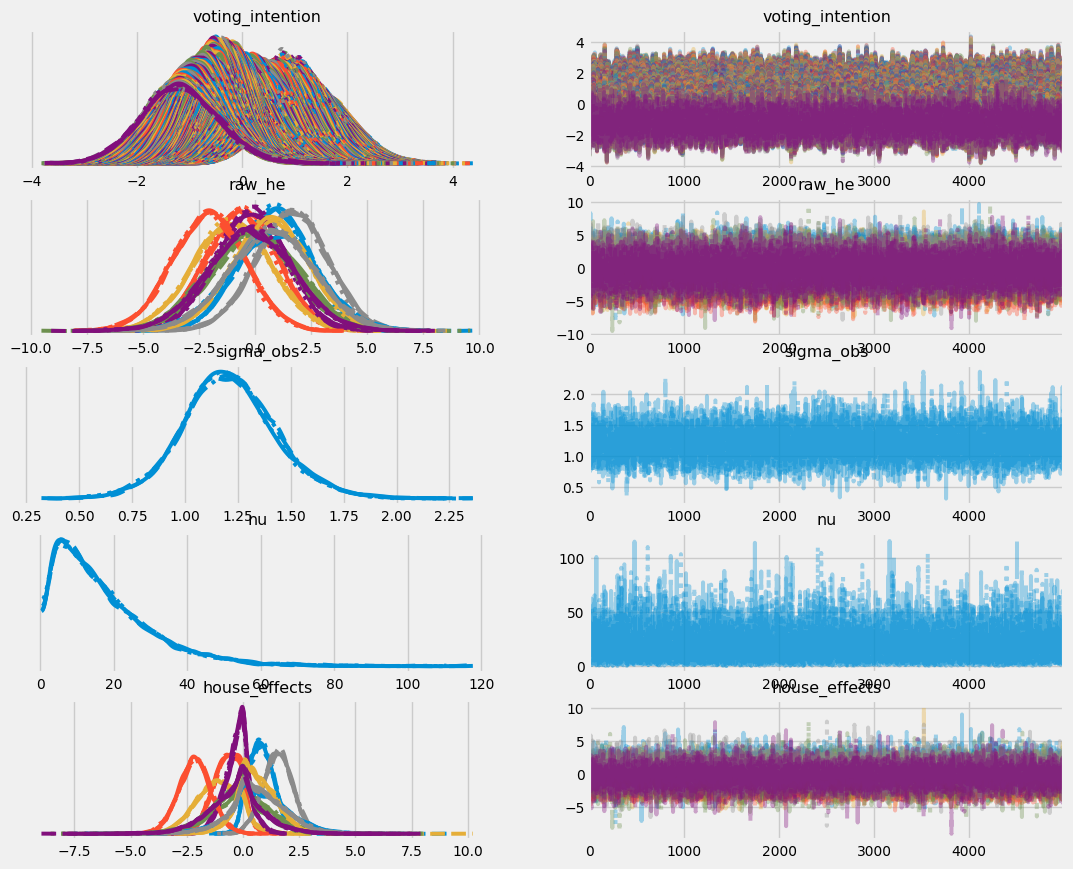

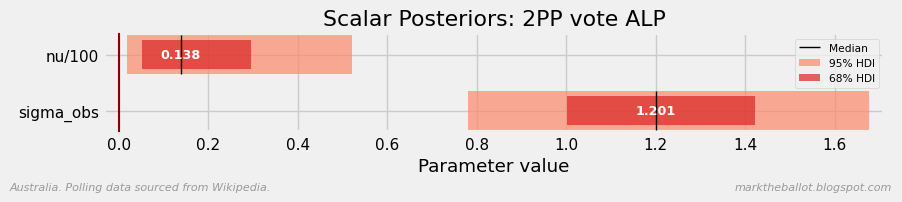

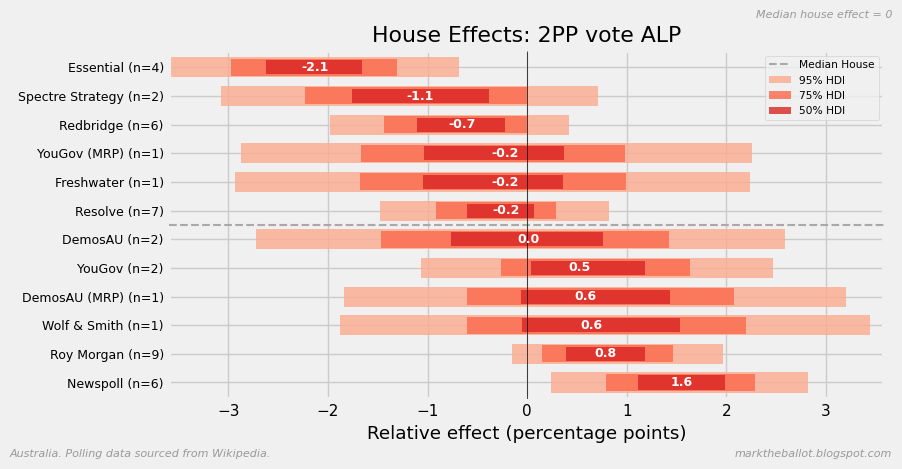

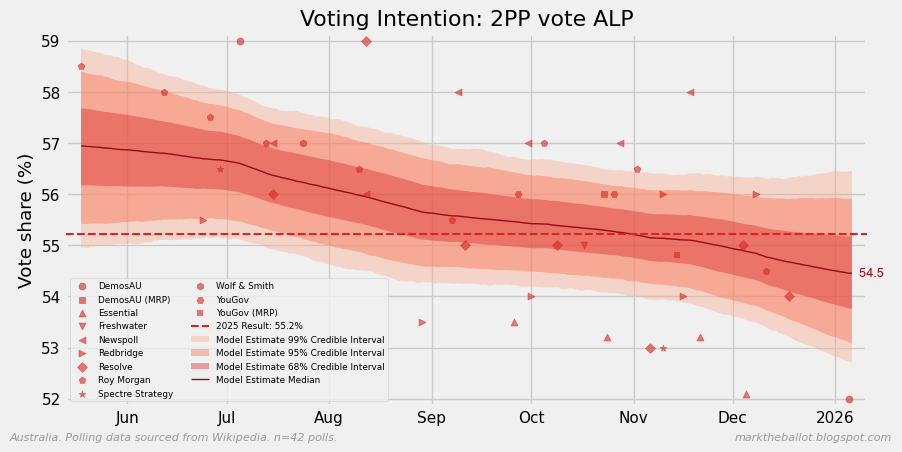


=== Residual Diagnostics by Pollster ===
Model sigma_obs: 1.21
Minimum polls required: 5

Roy Morgan (n=9)
  Outside ±3σ: 0/9 (0.0%)
  Heteroskedasticity p-value: 0.099 (homoskedastic)
  Recent outliers: 0@3σ, 0@2σ (of 5)
  Mean shift: -0.44 (t-test p=0.336)

Redbridge (n=6)
  Outside ±3σ: 0/6 (0.0%)
  Heteroskedasticity p-value: 0.314 (homoskedastic)
  Recent outliers: 0@3σ, 0@2σ (of 5)
  Mean shift: +1.88 (t-test p=0.103)

Newspoll (n=6)
  Outside ±3σ: 0/6 (0.0%)
  Heteroskedasticity p-value: 0.776 (homoskedastic)
  Recent outliers: 0@3σ, 0@2σ (of 5)
  Mean shift: +1.03 (t-test p=0.296)

Resolve (n=7)
  Outside ±3σ: 0/7 (0.0%)
  Heteroskedasticity p-value: 0.460 (homoskedastic)
  Recent outliers: 0@3σ, 0@2σ (of 5)
  Mean shift: -1.49 (t-test p=0.332)

✓ No pollsters flagged for methodology concerns.

Processing: 2PP vote L/NP
Polls: 42
Pollsters: ['Roy Morgan', 'Resolve', 'Redbridge', 'Newspoll', 'Essential', 'DemosAU', 'Spectre Strategy', 'YouGov', 'YouGov (MRP)', 'DemosAU (MRP)', 

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

Maximum R-hat: 1.0000
Minimum ESS: 2927
Maximum MCSE/sd ratio: 0.019
Divergent transitions: 0/20000 (0.0000%)
Tree depth at max (11): 0.56% (comparing to observed max)
Minimum BFMI: 0.95
Completed: 2PP vote L/NP


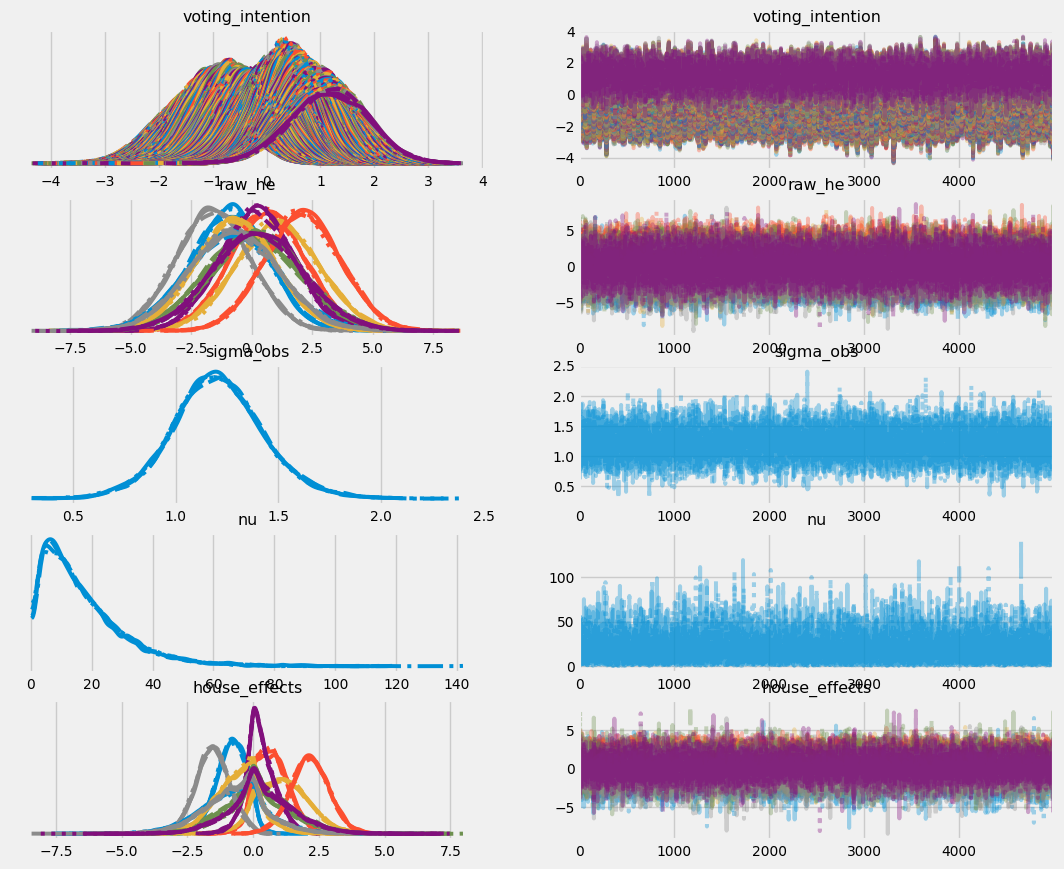

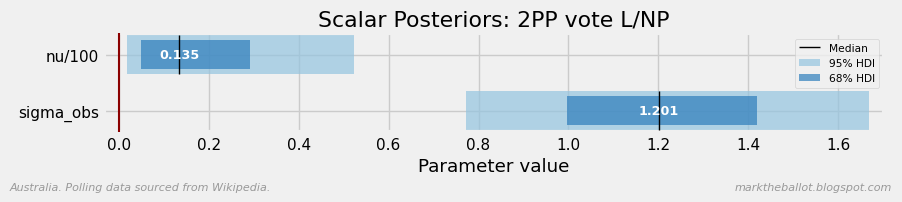

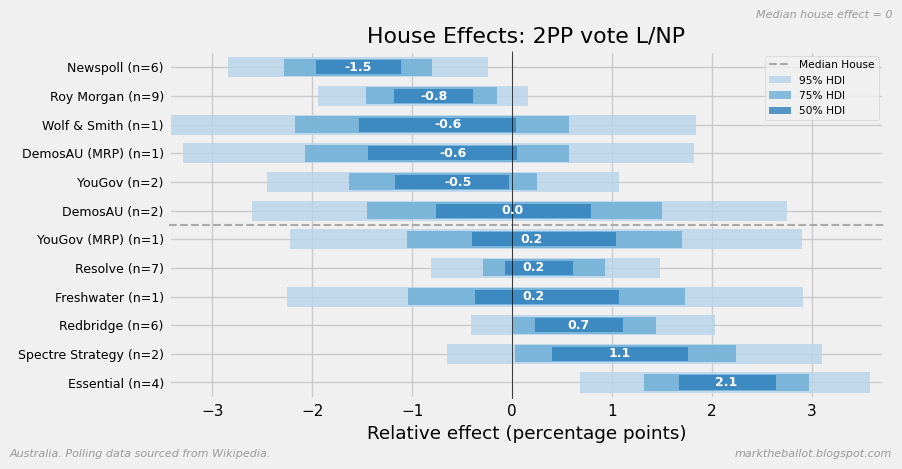

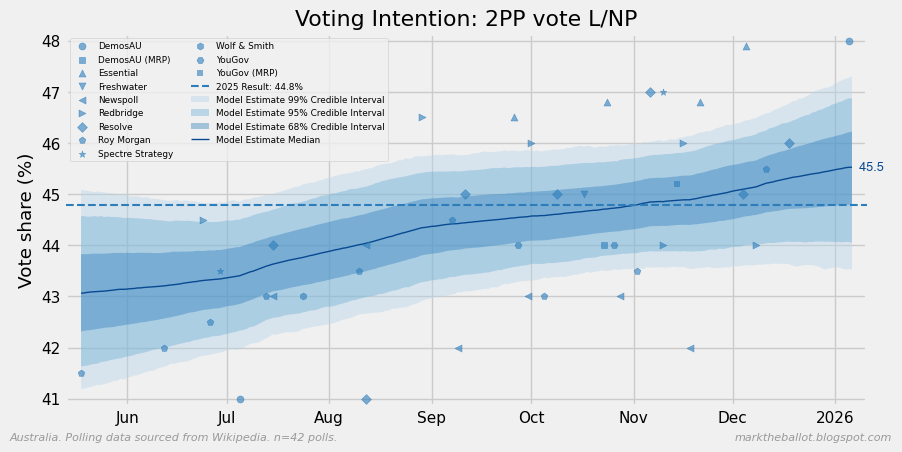


=== Residual Diagnostics by Pollster ===
Model sigma_obs: 1.21
Minimum polls required: 5

Roy Morgan (n=9)
  Outside ±3σ: 0/9 (0.0%)
  Heteroskedasticity p-value: 0.099 (homoskedastic)
  Recent outliers: 0@3σ, 0@2σ (of 5)
  Mean shift: +0.45 (t-test p=0.332)

Redbridge (n=6)
  Outside ±3σ: 0/6 (0.0%)
  Heteroskedasticity p-value: 0.312 (homoskedastic)
  Recent outliers: 0@3σ, 0@2σ (of 5)
  Mean shift: -1.88 (t-test p=0.103)

Newspoll (n=6)
  Outside ±3σ: 0/6 (0.0%)
  Heteroskedasticity p-value: 0.768 (homoskedastic)
  Recent outliers: 0@3σ, 0@2σ (of 5)
  Mean shift: -1.03 (t-test p=0.297)

Resolve (n=7)
  Outside ±3σ: 0/7 (0.0%)
  Heteroskedasticity p-value: 0.461 (homoskedastic)
  Recent outliers: 0@3σ, 0@2σ (of 5)
  Mean shift: +1.50 (t-test p=0.330)

✓ No pollsters flagged for methodology concerns.

Processing: Primary vote ALP
Polls: 42
Pollsters: ['Roy Morgan', 'Resolve', 'Redbridge', 'Newspoll', 'Essential', 'DemosAU', 'YouGov (MRP)', 'Spectre Strategy', 'DemosAU (MRP)', 'YouGov

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

Maximum R-hat: 1.0000
Minimum ESS: 3217
Maximum MCSE/sd ratio: 0.019
Divergent transitions: 0/20000 (0.0000%)
Tree depth at max (11): 0.56% (comparing to observed max)
Minimum BFMI: 0.97
Completed: Primary vote ALP


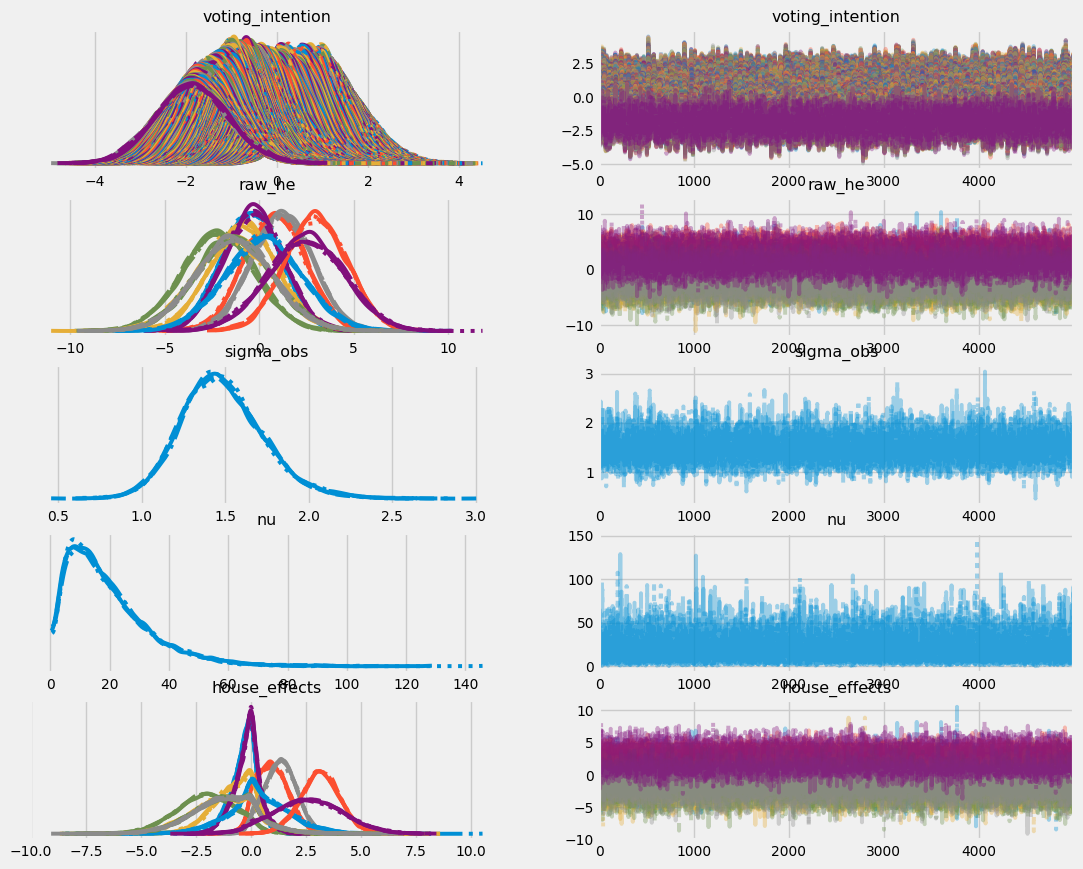

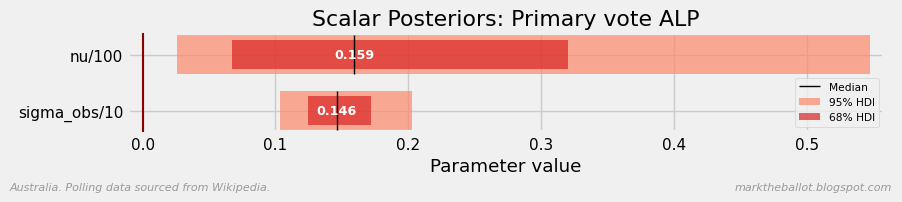

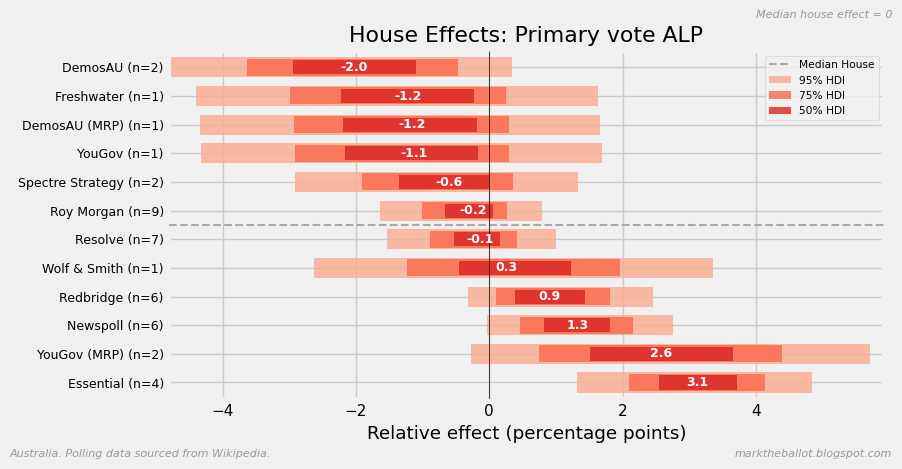

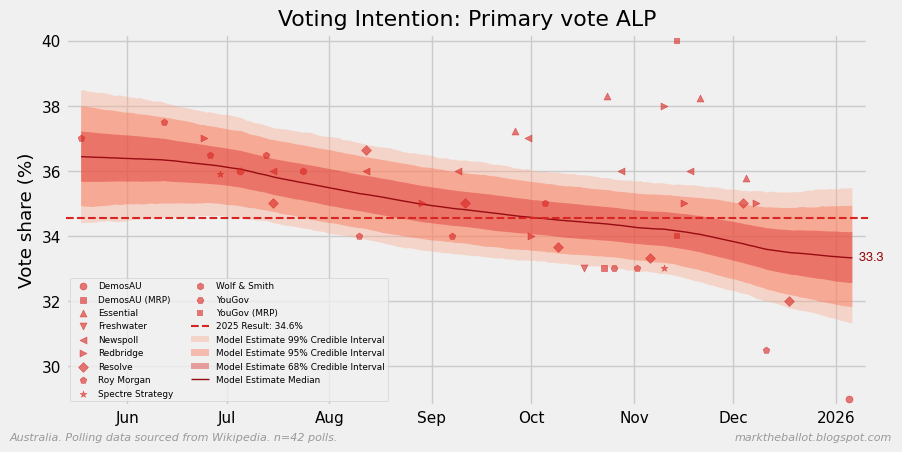


=== Residual Diagnostics by Pollster ===
Model sigma_obs: 1.48
Minimum polls required: 5

Roy Morgan (n=9) ⚠️ SUSPECT
  Outside ±3σ: 0/9 (0.0%)
  Heteroskedasticity p-value: 0.133 (homoskedastic)
  Recent outliers: 0@3σ, 0@2σ (of 5)
  Mean shift: -1.89 (t-test p=0.027)

Redbridge (n=6)
  Outside ±3σ: 0/6 (0.0%)
  Heteroskedasticity p-value: 0.608 (homoskedastic)
  Recent outliers: 0@3σ, 0@2σ (of 5)
  Mean shift: +1.92 (t-test p=0.157)

Newspoll (n=6) ⚠️ SUSPECT
  Outside ±3σ: 0/6 (0.0%)
  Heteroskedasticity p-value: 0.350 (homoskedastic)
  Recent outliers: 0@3σ, 0@2σ (of 5)
  Mean shift: +1.31 (t-test p=0.024)

Resolve (n=7)
  Outside ±3σ: 0/7 (0.0%)
  Heteroskedasticity p-value: 0.534 (homoskedastic)
  Recent outliers: 0@3σ, 0@2σ (of 5)
  Mean shift: -0.74 (t-test p=0.435)

⚠️  2 pollster(s) flagged for potential methodology issues:
   - Roy Morgan
   - Newspoll


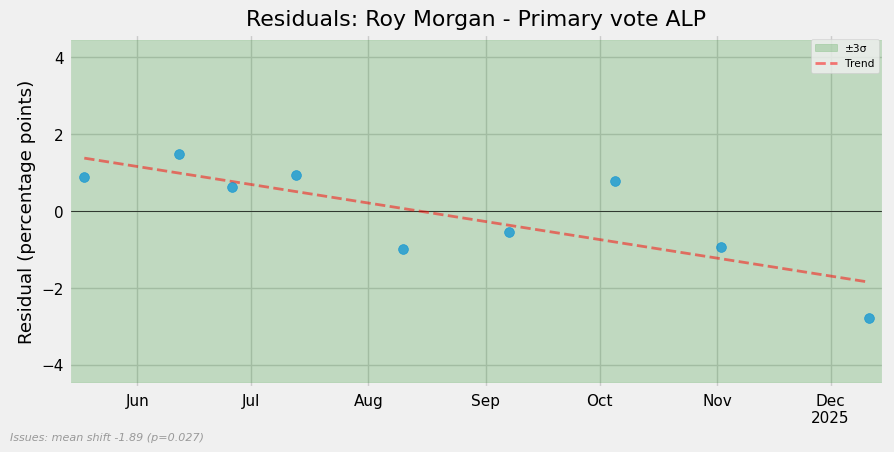

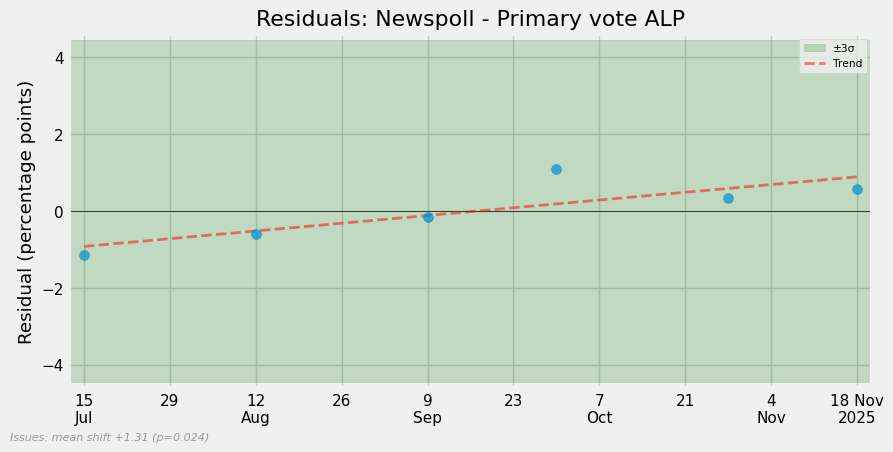


Processing: Primary vote L/NP
Polls: 42
Pollsters: ['Roy Morgan', 'Resolve', 'Redbridge', 'Newspoll', 'Essential', 'DemosAU', 'YouGov (MRP)', 'Spectre Strategy', 'DemosAU (MRP)', 'YouGov', 'Freshwater', 'Wolf & Smith']
Constraint: zero_median
sigma_obs HalfNormal prior: {'sigma': 5}
nu Gamma prior: {'alpha': 2, 'beta': 0.1}


  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

Maximum R-hat: 1.0000
Minimum ESS: 3681
Maximum MCSE/sd ratio: 0.017
Divergent transitions: 0/20000 (0.0000%)
Tree depth at max (11): 0.10% (comparing to observed max)
Minimum BFMI: 0.97
Completed: Primary vote L/NP


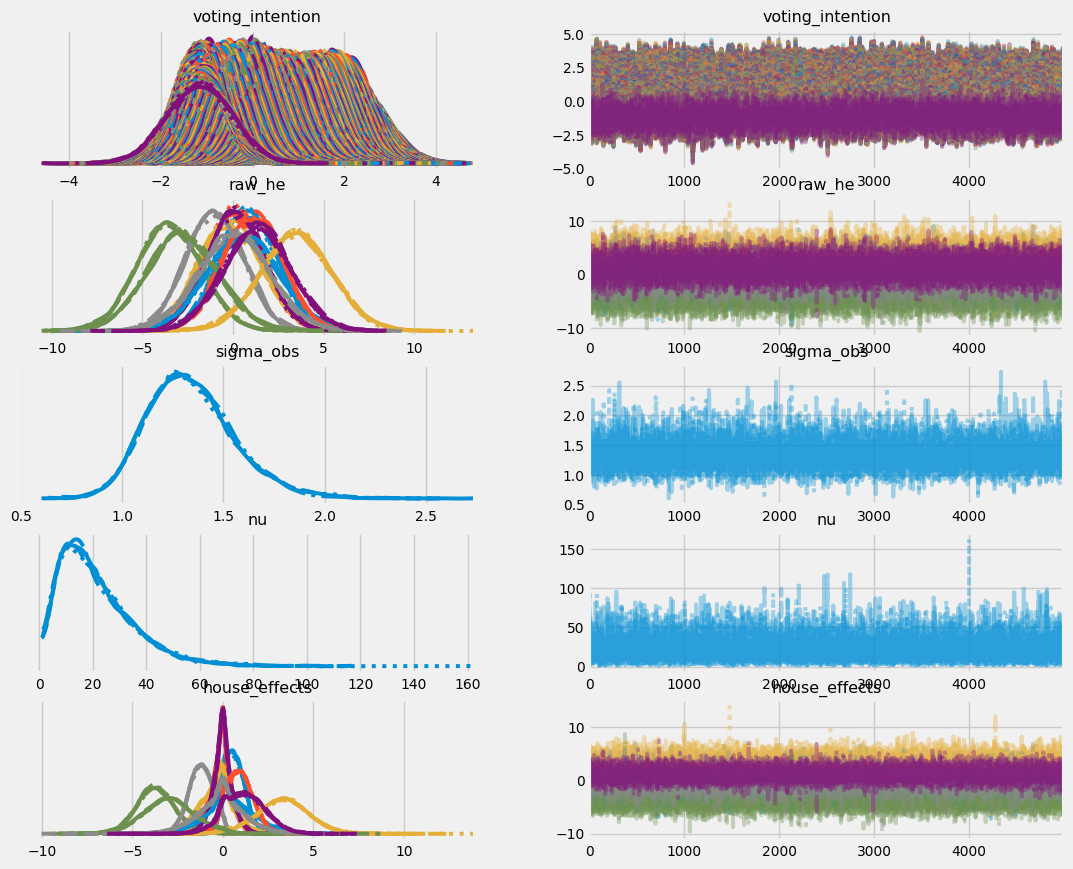

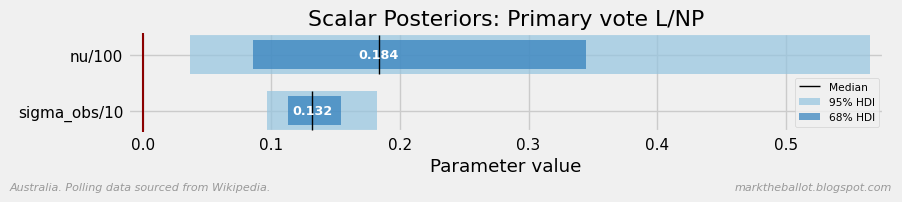

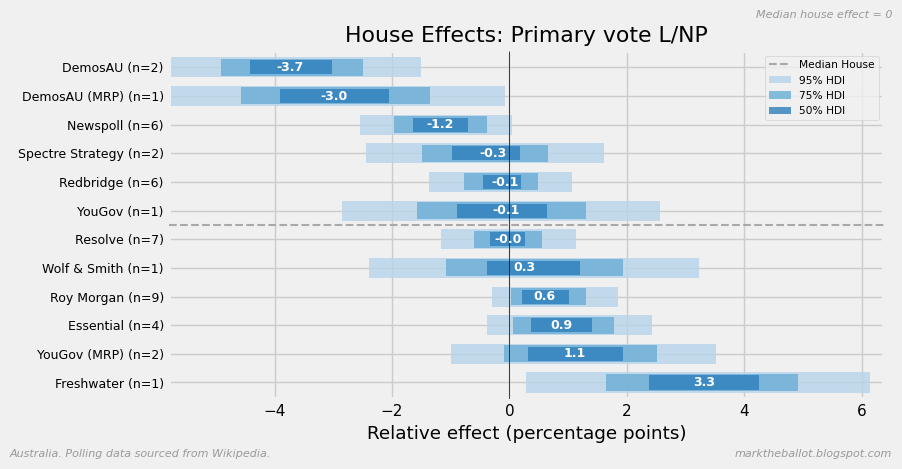

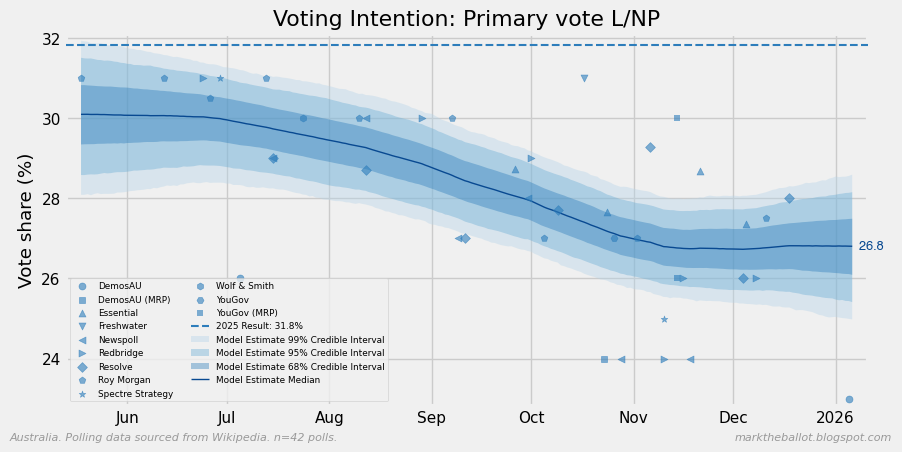


=== Residual Diagnostics by Pollster ===
Model sigma_obs: 1.34
Minimum polls required: 5

Roy Morgan (n=9)
  Outside ±3σ: 0/9 (0.0%)
  Heteroskedasticity p-value: 0.422 (homoskedastic)
  Recent outliers: 0@3σ, 0@2σ (of 5)
  Mean shift: -0.47 (t-test p=0.290)

Redbridge (n=6)
  Outside ±3σ: 0/6 (0.0%)
  Heteroskedasticity p-value: 0.789 (homoskedastic)
  Recent outliers: 0@3σ, 0@2σ (of 5)
  Mean shift: -2.50 (t-test p=0.067)

Newspoll (n=6)
  Outside ±3σ: 0/6 (0.0%)
  Heteroskedasticity p-value: 0.431 (homoskedastic)
  Recent outliers: 0@3σ, 0@2σ (of 5)
  Mean shift: -1.43 (t-test p=0.304)

Resolve (n=7)
  Outside ±3σ: 0/7 (0.0%)
  Heteroskedasticity p-value: 0.526 (homoskedastic)
  Recent outliers: 0@3σ, 0@2σ (of 5)
  Mean shift: +1.63 (t-test p=0.091)

✓ No pollsters flagged for methodology concerns.

Processing: Primary vote GRN
Polls: 41
Pollsters: ['Roy Morgan', 'Resolve', 'Redbridge', 'Newspoll', 'Essential', 'DemosAU', 'YouGov (MRP)', 'Spectre Strategy', 'DemosAU (MRP)', 'YouGov

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

Maximum R-hat: 1.0000
Minimum ESS: 3373
Maximum MCSE/sd ratio: 0.018
Divergent transitions: 0/20000 (0.0000%)
Tree depth at max (12): 0.11% (comparing to observed max)
Minimum BFMI: 0.99
Completed: Primary vote GRN


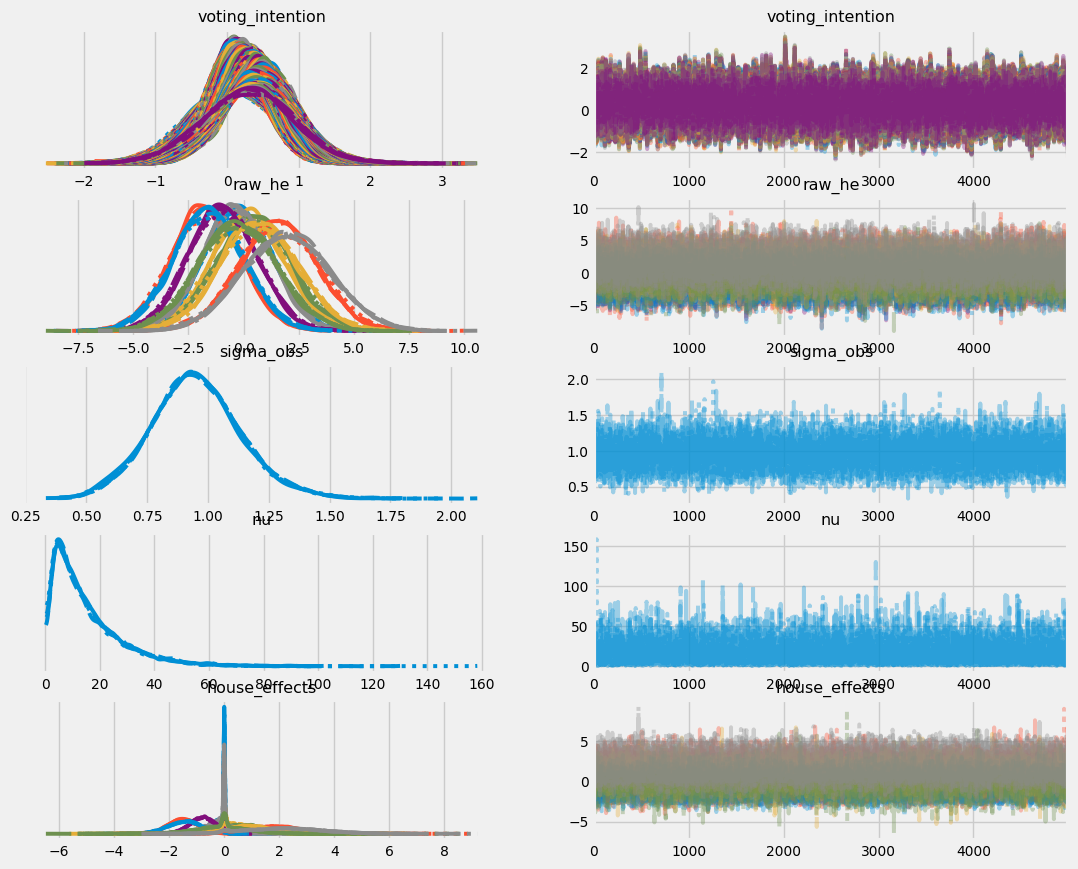

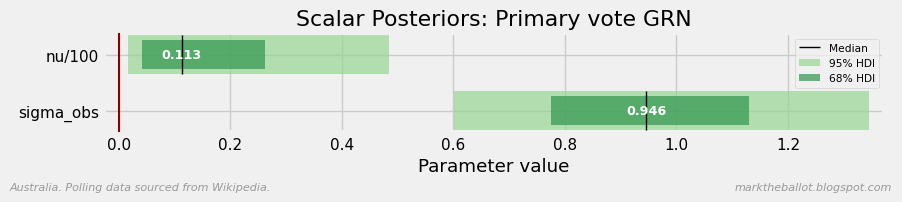

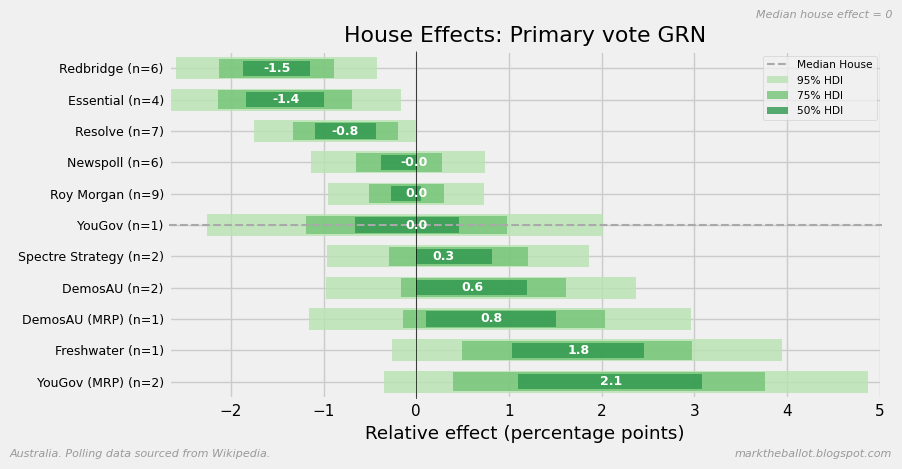

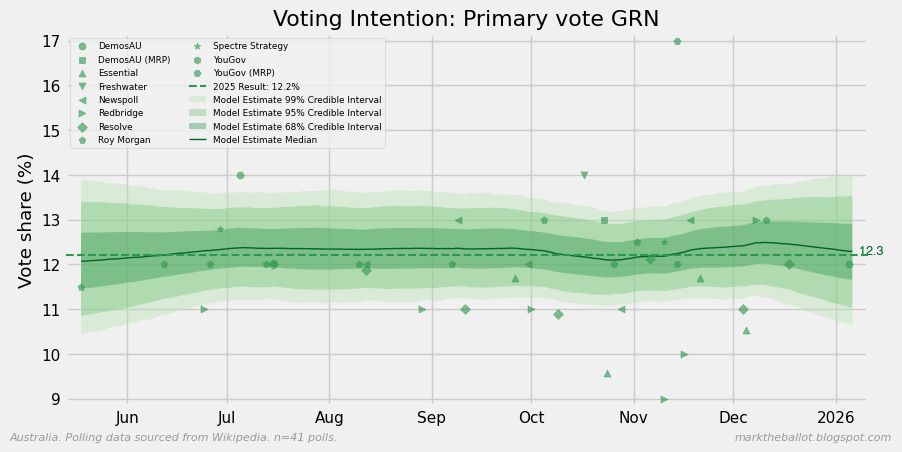


=== Residual Diagnostics by Pollster ===
Model sigma_obs: 0.95
Minimum polls required: 5

Roy Morgan (n=9)
  Outside ±3σ: 0/9 (0.0%)
  Heteroskedasticity p-value: 0.181 (homoskedastic)
  Recent outliers: 0@3σ, 0@2σ (of 5)
  Mean shift: +0.54 (t-test p=0.069)

Redbridge (n=6)
  Outside ±3σ: 0/6 (0.0%)
  Heteroskedasticity p-value: 0.115 (homoskedastic)
  Recent outliers: 0@3σ, 1@2σ (of 5)
  Mean shift: -0.31 (t-test p=0.805)

Newspoll (n=6)
  Outside ±3σ: 0/6 (0.0%)
  Heteroskedasticity p-value: 0.100 (homoskedastic)
  Recent outliers: 0@3σ, 0@2σ (of 5)
  Mean shift: -0.23 (t-test p=0.731)

Resolve (n=7)
  Outside ±3σ: 0/7 (0.0%)
  Heteroskedasticity p-value: 0.423 (homoskedastic)
  Recent outliers: 0@3σ, 0@2σ (of 5)
  Mean shift: -0.09 (t-test p=0.844)

✓ No pollsters flagged for methodology concerns.

Processing: Primary vote ONP
Polls: 41
Pollsters: ['Roy Morgan', 'Resolve', 'Redbridge', 'Newspoll', 'Essential', 'DemosAU', 'YouGov (MRP)', 'Spectre Strategy', 'DemosAU (MRP)', 'YouGov

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

Maximum R-hat: 1.0000
Minimum ESS: 1477
Maximum MCSE/sd ratio: 0.027
Divergent transitions: 0/20000 (0.0000%)
Tree depth at max (12): 0.01% (comparing to observed max)
Minimum BFMI: 0.95
Completed: Primary vote ONP


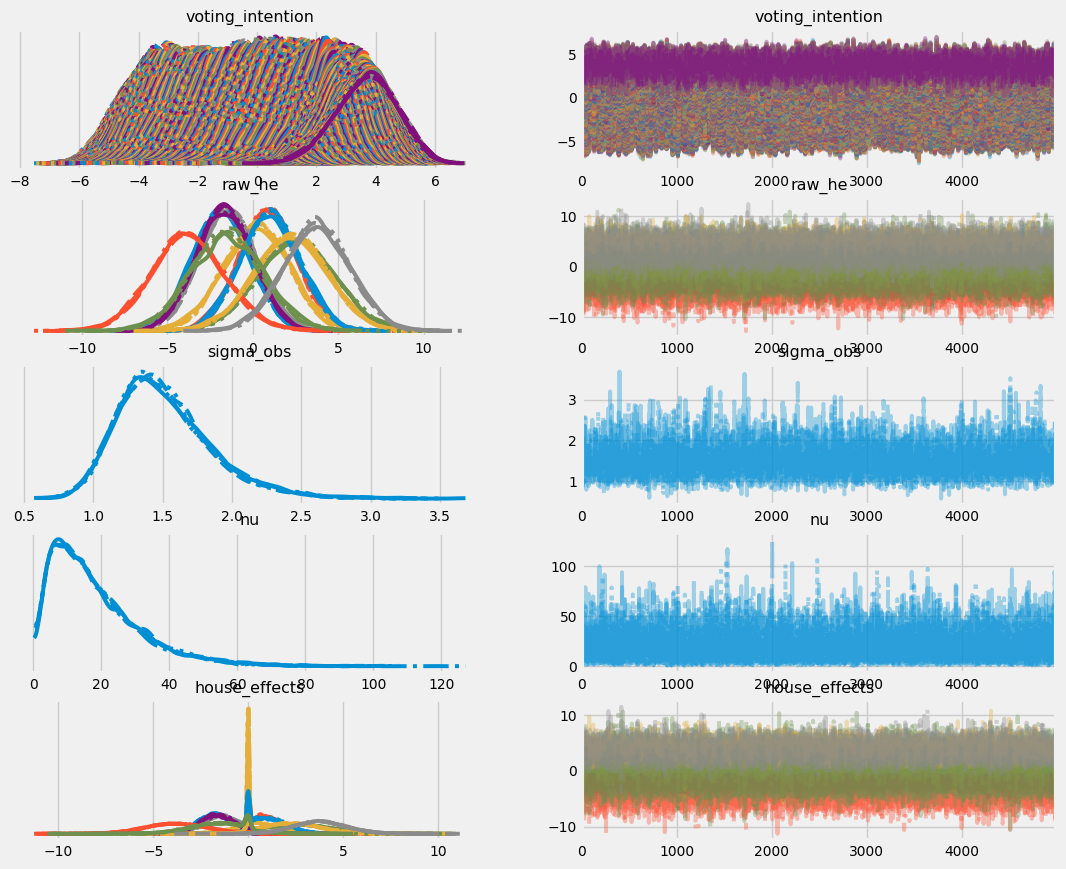

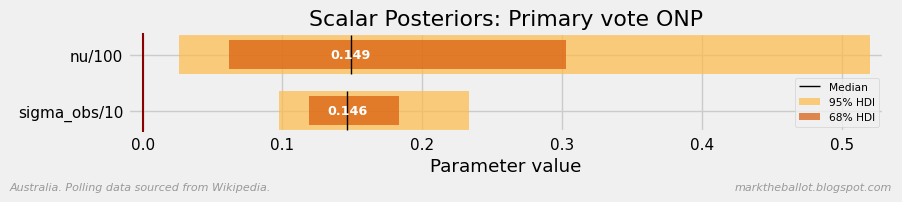

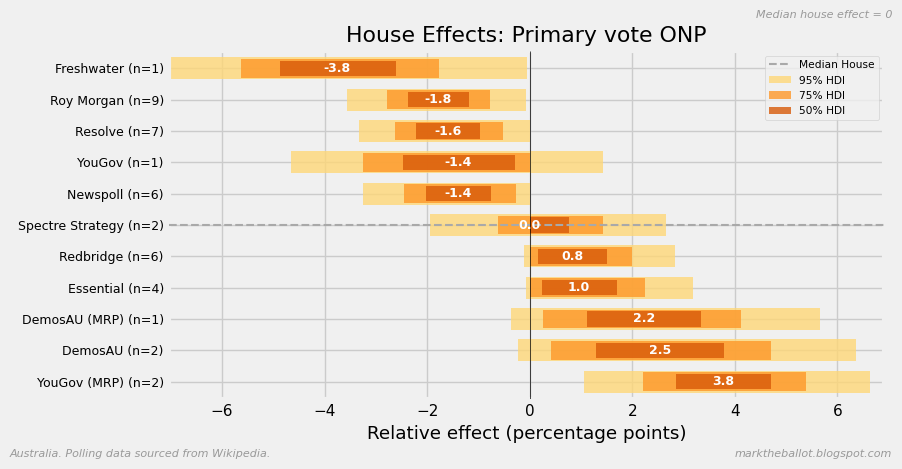

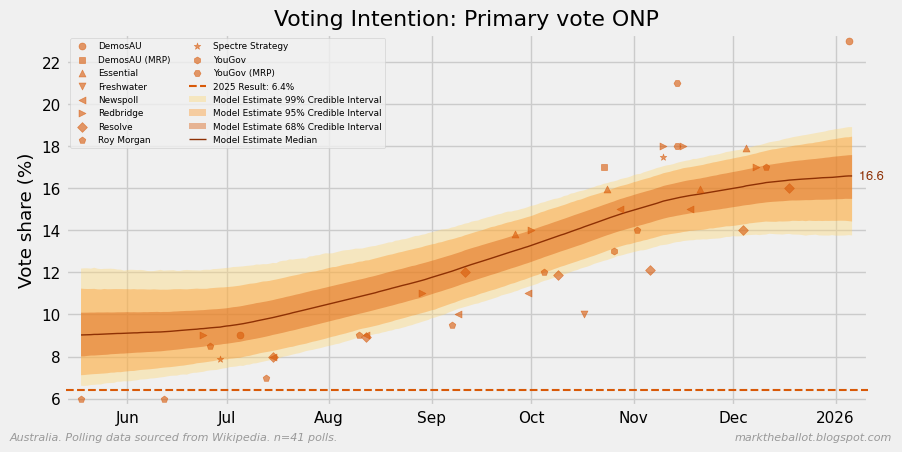


=== Residual Diagnostics by Pollster ===
Model sigma_obs: 1.51
Minimum polls required: 5

Roy Morgan (n=9)
  Outside ±3σ: 0/9 (0.0%)
  Heteroskedasticity p-value: 0.268 (homoskedastic)
  Recent outliers: 0@3σ, 0@2σ (of 5)
  Mean shift: +1.28 (t-test p=0.145)

Redbridge (n=6) ⚠️ SUSPECT
  Outside ±3σ: 0/6 (0.0%)
  Heteroskedasticity p-value: 0.810 (homoskedastic)
  Recent outliers: 0@3σ, 0@2σ (of 5)
  Mean shift: +2.07 (t-test p=0.046)

Newspoll (n=6)
  Outside ±3σ: 0/6 (0.0%)
  Heteroskedasticity p-value: 0.241 (homoskedastic)
  Recent outliers: 0@3σ, 0@2σ (of 5)
  Mean shift: +1.13 (t-test p=0.257)

Resolve (n=7)
  Outside ±3σ: 0/7 (0.0%)
  Heteroskedasticity p-value: 0.369 (homoskedastic)
  Recent outliers: 0@3σ, 0@2σ (of 5)
  Mean shift: -0.41 (t-test p=0.622)

⚠️  1 pollster(s) flagged for potential methodology issues:
   - Redbridge


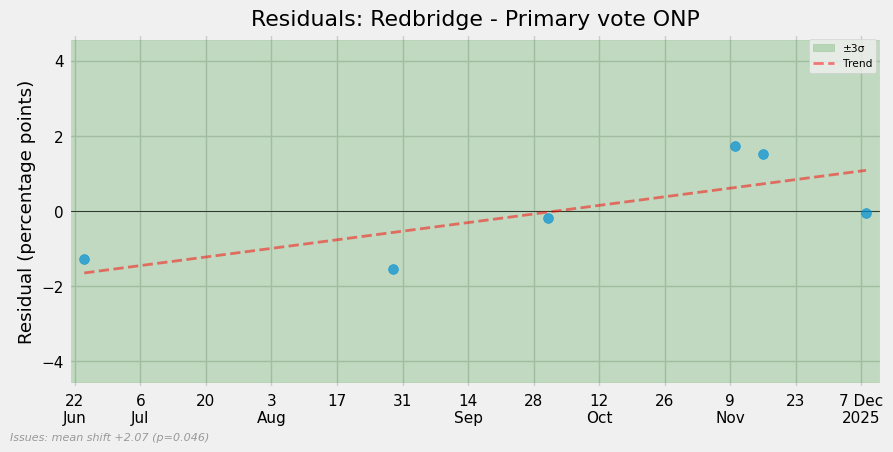


Processing: Others Primary Vote
Polls: 41
Pollsters: ['Roy Morgan', 'Resolve', 'Redbridge', 'Newspoll', 'Essential', 'DemosAU', 'YouGov (MRP)', 'Spectre Strategy', 'DemosAU (MRP)', 'YouGov', 'Freshwater']
Constraint: zero_median
sigma_obs HalfNormal prior: {'sigma': 5}
nu Gamma prior: {'alpha': 2, 'beta': 0.1}


  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

Maximum R-hat: 1.0000
Minimum ESS: 2473
Maximum MCSE/sd ratio: 0.021
Divergent transitions: 0/20000 (0.0000%)
Tree depth at max (11): 3.69% (comparing to observed max)
Minimum BFMI: 0.95
Completed: Others Primary Vote


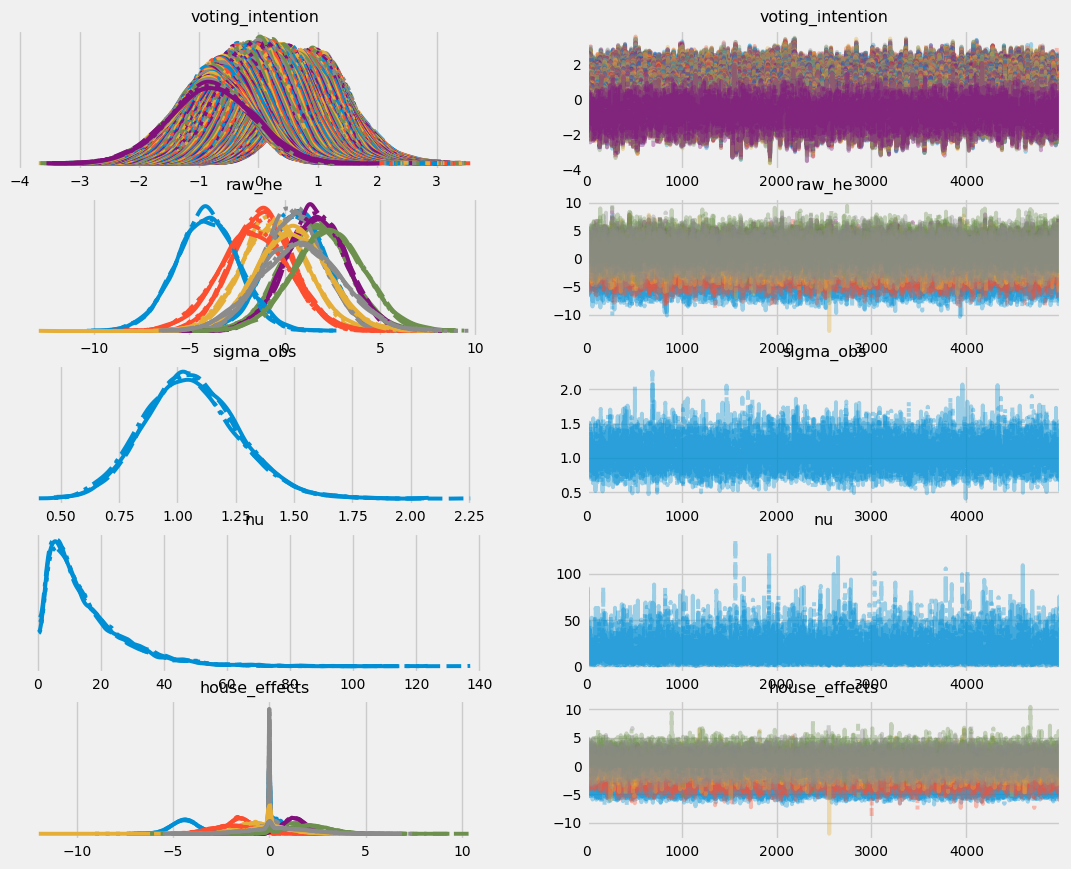

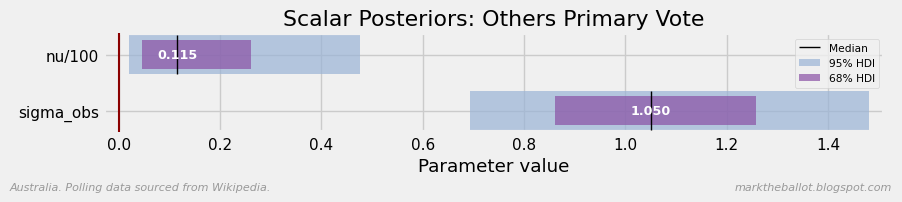

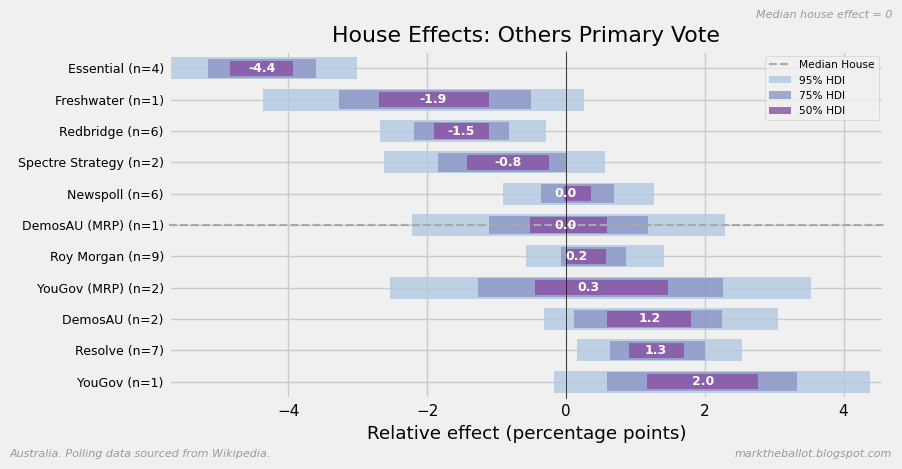

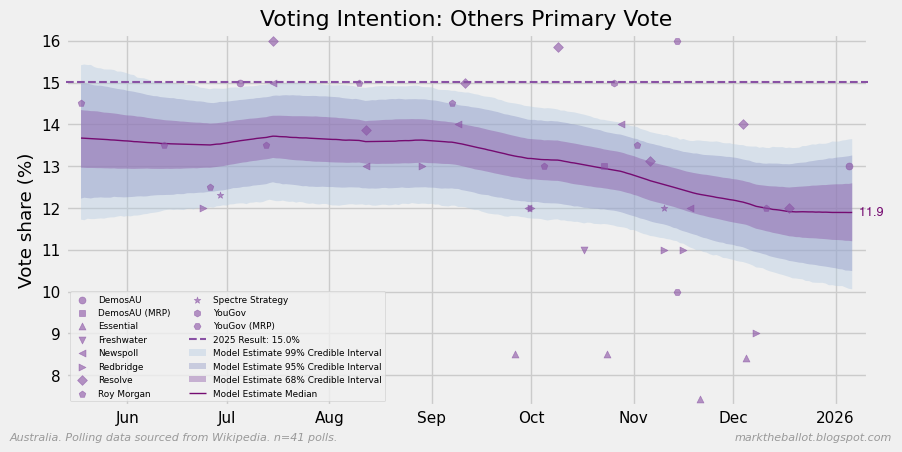


=== Residual Diagnostics by Pollster ===
Model sigma_obs: 1.06
Minimum polls required: 5

Roy Morgan (n=9)
  Outside ±3σ: 0/9 (0.0%)
  Heteroskedasticity p-value: 0.409 (homoskedastic)
  Recent outliers: 0@3σ, 0@2σ (of 5)
  Mean shift: +0.68 (t-test p=0.203)

Redbridge (n=6)
  Outside ±3σ: 0/6 (0.0%)
  Heteroskedasticity p-value: 0.411 (homoskedastic)
  Recent outliers: 0@3σ, 0@2σ (of 5)
  Mean shift: -0.91 (t-test p=0.213)

Newspoll (n=6)
  Outside ±3σ: 0/6 (0.0%)
  Heteroskedasticity p-value: 0.655 (homoskedastic)
  Recent outliers: 0@3σ, 0@2σ (of 5)
  Mean shift: -0.54 (t-test p=0.568)

Resolve (n=7)
  Outside ±3σ: 0/7 (0.0%)
  Heteroskedasticity p-value: 0.912 (homoskedastic)
  Recent outliers: 0@3σ, 0@2σ (of 5)
  Mean shift: -0.08 (t-test p=0.932)

✓ No pollsters flagged for methodology concerns.


In [11]:
# Run model for each column
results = {}

for column in VOTE_COLUMNS:
    results[column] = run_grw_for_column(df, column)
    inputs = results[column]["inputs"]
    idata = results[column]["idata"]
    glitches = results[column]["glitches"]
    constraint = results[column]["constraint"]
    poll_counts = results[column]["poll_counts"]
    
    # Plot scalar posteriors (sigma_likelihood, nu, etc.)
    plot_posteriors_bar(
        idata,
        series_name=column,
        rfooter=RFOOTER,
        lfooter=LFOOTER,
        palette=get_palette(column),
        show=SHOW,
    )
    
    # Plot house effects
    if constraint == "zero_median":
        rheader = "Median house effect = 0"
    else:
        he_sum_inclusions = inputs["he_sum_inclusions"]
        rheader = f"Sum to zero: {', '.join(he_sum_inclusions)}"
    plot_house_effects_bar(
        idata,
        inputs["back_firm_map"],
        model_name=column,
        poll_counts=poll_counts,
        palette=get_palette(column),
        rheader=rheader,
        rfooter=RFOOTER,
        lfooter=LFOOTER,
        show=SHOW,
    )
    
    # Prepare poll data for plotting (needs PeriodIndex)
    df_plot = df[df[column].replace(0, np.nan).notna()].copy()
    df_plot.index = pd.PeriodIndex(df_plot[MIDDLE_DATE], freq="D")
    n_polls = len(df_plot)
    assert n_polls == sum(poll_counts.values()) 
    
    # Plot voting intention time series
    # Note: voting_intention is zero-centered; centre_offset is -mean, so subtract to restore
    vi_samples = get_vector_var("voting_intention", idata)
    vi_samples = vi_samples - inputs["centre_offset"]  # Restore original scale
    # GaussianRandomWalk creates steps+1 values, so use actual length
    date_index = pd.period_range(inputs["day_zero"], periods=len(vi_samples), freq="D")
    vi_samples.index = date_index
    
    plot_posterior_timeseries(
        data=vi_samples,
        poll_data=df_plot,
        poll_column=column,
        election_result=get_election_result(column),
        palette=get_palette(column),
        title=f"Voting Intention: {column}",
        ylabel="Vote share (%)",
        legend={"loc": "best", "fontsize": "xx-small", "ncol": 2},
        lheader=glitches if glitches else "",
        rfooter=RFOOTER,
        lfooter=f"{LFOOTER}n={n_polls} polls.",
        show=SHOW,
    )
    
    # Check residuals for potential methodology changes
    residual_df = check_residuals(inputs, idata, verbose=True, show=SHOW)

## Finished

In [12]:
%load_ext watermark
%watermark -t -d -u --python --machine --conda --iversions --watermark

Last updated: 2026-01-09 19:30:05

Python implementation: CPython
Python version       : 3.14.0
IPython version      : 9.8.0

conda environment: n/a

Compiler    : Clang 20.1.4 
OS          : Darwin
Release     : 25.2.0
Machine     : arm64
Processor   : arm
CPU cores   : 14
Architecture: 64bit

pathlib   : 1.0.1
arviz     : 0.22.0
pandas    : 2.3.3
numpy     : 2.3.5
sys       : 3.14.0 (main, Oct 10 2025, 12:54:13) [Clang 20.1.4 ]
mgplot    : 0.2.14
matplotlib: 3.10.7

Watermark: 2.5.0

